In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year
    #df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    #df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    #pd.set_option('display.max_rows', None)
    #df = df.drop(['hour'])
    #print(df['sin_hour'])
    
    return df

In [3]:
def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
   #bruk lasso regularisering
   #annen learing rate, 0.0001
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])
    
    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    # Convert 'time' to datetime if it isn't already
    

# Extract hour and group by it to get the index of maximum value in each group
    '''idx = targets.groupby([targets['time'].dt.date, targets['time'].dt.hour])['pv_measurement'].idxmax()


# Use the indices to get the corresponding rows from the original dataframe
    targets_max = targets.loc[idx].reset_index(drop=True)
    targets_mean = targets.set_index('time').resample('1H').mean().dropna(how='all').reset_index()
    pd.set_option('display.max_rows', None)'''
    #print(targets_max, 'max')
    #print(targets_mean, 'mean')
    

# Assuming you already have your dataframes: observed, estimated, test


    '''def process_data(df):
      # Shift date by 30 minutes
      df['date_forecast'] = df['date_forecast'] + pd.Timedelta(minutes=30)
      
      # Resample to 1H frequency
      resampled = df.set_index('date_forecast').resample('1H').mean().reset_index()
      
      # Drop the last row if it's the last half hour of data
      
      resampled = resampled.iloc[:-1]
      
      return resampled
    pd.set_option('display.max_rows', None)

    
    print(estimated)
    observed_resampled = process_data(observed)
    estimated_resampled = process_data(estimated)
    test_resampled = process_data(test)'''
    #This code will first shift the data by 30 minutes, then resample it into 1-hour intervals, and finally drop the last row if it represents less than a full hour of data.




    
    # Start the resampling from 30 minutes past the hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    pd.set_option('display.max_rows', None)
    print(date_calc_resampled_ob)
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #print(estimated_resampled.dtypes)
    #print(estimated_resampled[['date_forecast','date_calc']])
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date

    def process_data(observed, estimated, test):
    # Assuming 'date_forecast' is the datetime column for both dataframes.
    
    # 1. Create time-delta for estimated data
      estimated['time_dummy'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      observed['time_dummy'] = 0 
      test['time_dummy'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      pd.set_option('display.max_rows', None)
      #print(estimated['time_delta'])
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
      pd.set_option('display.max_rows', None)
      #print(estimated['time_delta'])
      #print(test['time_delta'])
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1
      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      #print(df['time_delta'])
      return df, test
   
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)
    # Merge the observed and estimated data
    #weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    if merged_data.empty:
      print(f"merged_data is empty for location ")
    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    #print(targets.dtypes)
    # Clean up auxiliary columns
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets_ny, start_date, end_date)
    if observed_resampled.empty:
      print(f"observed_resampled is empty for location ")
    # Drop non-feature columns
    print(test_resampled[ 'date_forecast'])
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast', 'date_calc'])
    #print(test_resampled.dtypes)
    #print(filtered_data.dtypes)
    return filtered_data, test_resampled, is_day_feature, targets_ny

In [5]:
from pycaret.regression import *
def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    #silent=True, 
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    # First, create multiple models
    '''cat = create_model('catboost')
    rf= create_model('rf')
    et = create_model('et')
    lasso = create_model('llar')'''
    #best = compare_models(include=['catboost', 'lightgbm','rf','et', 'llar'])
    # Blend models
    #blended = blend_models(best)

    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm, choose_better=True)#, early_stopping=True, fold=15)
    print(tuned_lightgbm)
    '''tuned_cat = tune_model(cat, choose_better=True)
    tuned_rf = tune_model(rf, choose_better=True)
    tuned_et = tune_model(et, choose_better=True)
    tuned_lasso = tune_model(lasso, choose_better=True)'''
    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    '''bagged_cat = ensemble_model(tuned_cat, method='Bagging')
    bagged_rf = ensemble_model(tuned_rf, method='Bagging')
    bagged_et = ensemble_model(tuned_et, method='Bagging')
    bagged_lasso = ensemble_model(tuned_lasso, method='Bagging')
    #boost_lightgbm = ensemble_model(bagged_lightgbm, method='Boosting')
    # Finalize the model - this will train it on the complete dataset
    blender = blend_models([bagged_lightgbm,bagged_cat,bagged_rf,bagged_et,bagged_lasso])
    print(blender)'''
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

In [6]:
help(blend_models)

Help on function blend_models in module pycaret.regression.functional:

blend_models(estimator_list: list, fold: Union[int, Any, NoneType] = None, round: int = 4, choose_better: bool = False, optimize: str = 'R2', weights: Union[List[float], NoneType] = None, fit_kwargs: Union[dict, NoneType] = None, groups: Union[str, Any, NoneType] = None, verbose: bool = True, return_train_score: bool = False)
    This function trains a Voting Regressor for select models passed in the
    ``estimator_list`` param. The output of this function is a score grid with
    CV scores by fold. Metrics evaluated during CV can be accessed using the
    ``get_metrics`` function. Custom metrics can be added or removed using
    ``add_metric`` and ``remove_metric`` function.
    
    
    Example
    --------
    >>> from pycaret.datasets import get_data
    >>> boston = get_data('boston')
    >>> from pycaret.regression import *
    >>> exp_name = setup(data = boston,  target = 'medv')
    >>> top3 = compare_mod

In [7]:
help(setup)

Help on function setup in module pycaret.regression.functional:

setup(data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, data_func: Union[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame]], NoneType] = None, target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1, index: Union[bool, int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = True, train_size: float = 0.7, test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, ordinal_features: Union[Dict[str, list], NoneType] = None, numeric_features: Union[List[str], NoneType] = None, categorical_features: Union[List[str], NoneType] = None, date_features: Union[List[str], NoneType] = None, text_features: Union[List[str], NoneType] = None, ignore_features: Union[List[str], NoneType] = None, keep_feat

                              date_calc
date_forecast                          
2022-10-28 22:00:00 2022-10-27 07:00:18
2022-10-28 23:00:00 2022-10-27 07:00:18
2022-10-29 00:00:00 2022-10-28 07:00:05
2022-10-29 01:00:00 2022-10-28 07:00:05
2022-10-29 02:00:00 2022-10-28 07:00:05
2022-10-29 03:00:00 2022-10-28 07:00:05
2022-10-29 04:00:00 2022-10-28 07:00:05
2022-10-29 05:00:00 2022-10-28 07:00:05
2022-10-29 06:00:00 2022-10-28 07:00:05
2022-10-29 07:00:00 2022-10-28 07:00:05
2022-10-29 08:00:00 2022-10-28 07:00:05
2022-10-29 09:00:00 2022-10-28 07:00:05
2022-10-29 10:00:00 2022-10-28 07:00:05
2022-10-29 11:00:00 2022-10-28 07:00:05
2022-10-29 12:00:00 2022-10-28 07:00:05
2022-10-29 13:00:00 2022-10-28 07:00:05
2022-10-29 14:00:00 2022-10-28 07:00:05
2022-10-29 15:00:00 2022-10-28 07:00:05
2022-10-29 16:00:00 2022-10-28 07:00:05
2022-10-29 17:00:00 2022-10-28 07:00:05
2022-10-29 18:00:00 2022-10-28 07:00:05
2022-10-29 19:00:00 2022-10-28 07:00:05
2022-10-29 20:00:00 2022-10-28 07:00:05


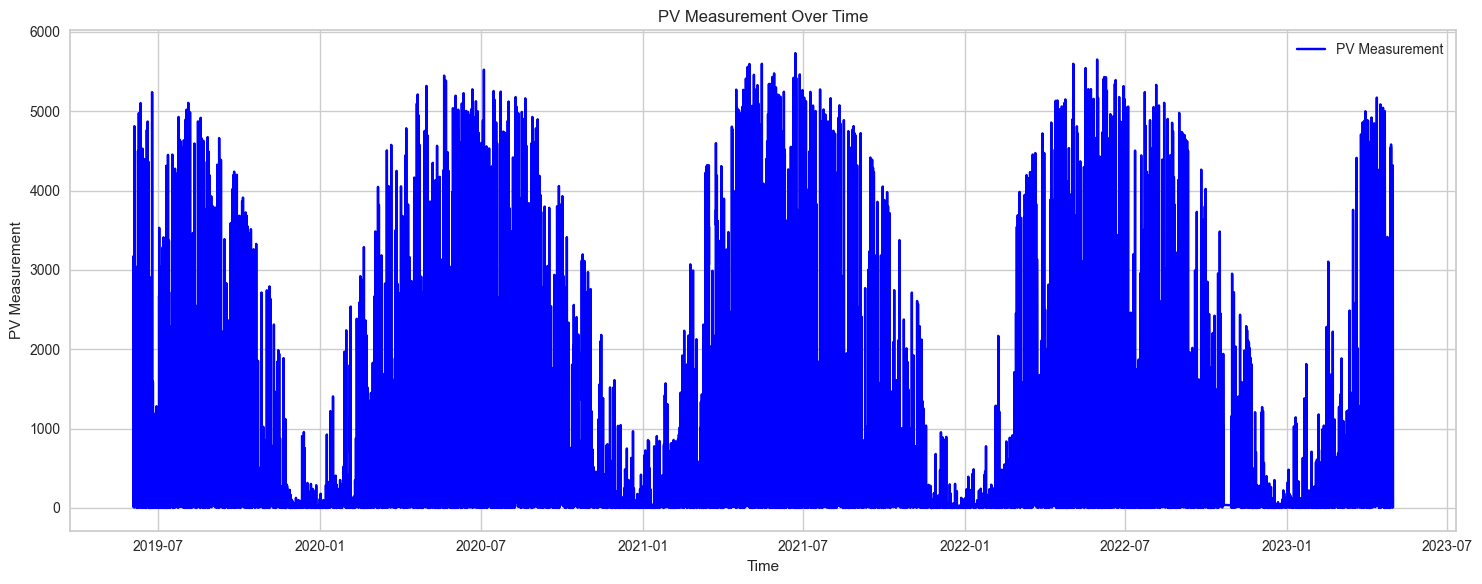

0     2023-05-01 00:00:00
1     2023-05-01 01:00:00
2     2023-05-01 02:00:00
3     2023-05-01 03:00:00
4     2023-05-01 04:00:00
5     2023-05-01 05:00:00
6     2023-05-01 06:00:00
7     2023-05-01 07:00:00
8     2023-05-01 08:00:00
9     2023-05-01 09:00:00
10    2023-05-01 10:00:00
11    2023-05-01 11:00:00
12    2023-05-01 12:00:00
13    2023-05-01 13:00:00
14    2023-05-01 14:00:00
15    2023-05-01 15:00:00
16    2023-05-01 16:00:00
17    2023-05-01 17:00:00
18    2023-05-01 18:00:00
19    2023-05-01 19:00:00
20    2023-05-01 20:00:00
21    2023-05-01 21:00:00
22    2023-05-01 22:00:00
23    2023-05-01 23:00:00
24    2023-05-06 00:00:00
25    2023-05-06 01:00:00
26    2023-05-06 02:00:00
27    2023-05-06 03:00:00
28    2023-05-06 04:00:00
29    2023-05-06 05:00:00
30    2023-05-06 06:00:00
31    2023-05-06 07:00:00
32    2023-05-06 08:00:00
33    2023-05-06 09:00:00
34    2023-05-06 10:00:00
35    2023-05-06 11:00:00
36    2023-05-06 12:00:00
37    2023-05-06 13:00:00
38    2023-0

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     337.6181  275885.0663  525.2476  0.8440  0.9119  4.3472
1     307.4603  251873.4928  501.8700  0.8549  0.8602  2.5487
2     324.9158  278925.2306  528.1337  0.8484  0.8957  2.6479
3     342.9796  305102.7982  552.3611  0.8447  0.8681  2.9090
4     336.2405  290457.3108  538.9409  0.8368  0.8612  2.2307
5     344.4106  312159.6186  558.7125  0.8391  0.7986  1.9445
6     327.1328  290667.9764  539.1363  0.8459  0.8303  1.8144
7     341.8931  314760.6831  561.0354  0.8436  0.8853  3.1250
8     324.4143  279166.9533  528.3625  0.8473  0.8712  3.0372
9     343.9022  318485.9995  564.3456  0.8443  0.8540  2.7213
Mean  333.0967  291748.5130  539.8146  0.8449  0.8637  2.7326
Std    11.3369   20016.5843   18.6747  0.0047  0.0306  0.6813


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     333.5446  267079.3821  516.7972  0.8489  1.0046  6.0575
1     301.6701  230290.3258  479.8857  0.8673  0.9852  3.7272
2     313.6739  252856.7776  502.8487  0.8626  0.9595  3.7804
3     334.4189  287982.4694  536.6400  0.8534  0.9557  3.8045
4     328.3327  278162.6819  527.4113  0.8437  0.9652  3.8440
5     339.7286  298362.9103  546.2261  0.8462  0.8946  2.9616
6     322.9557  278726.0589  527.9451  0.8522  0.9422  3.2084
7     337.5657  305591.0823  552.8029  0.8481  0.9315  3.5197
8     316.0456  259395.8059  509.3091  0.8581  0.9250  3.9072
9     335.1330  296901.8293  544.8870  0.8549  0.9800  3.7530
Mean  326.3069  275534.9324  524.4753  0.8535  0.9543  3.8563
Std    11.7906   22240.5112   21.4610  0.0070  0.0306  0.7885


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     352.1211  307879.4868  554.8689  0.8259  0.7581  2.0975
1     320.5457  279838.5968  528.9977  0.8387  0.7560  1.7519
2     334.4036  298445.4108  546.3016  0.8378  0.7502  1.4257
3     348.6629  319589.2258  565.3222  0.8373  0.7301  1.4193
4     346.2370  313528.5821  559.9362  0.8239  0.7336  1.3137
5     358.3582  339161.1873  582.3755  0.8251  0.7081  1.1005
6     338.3884  310642.4004  557.3530  0.8353  0.7112  1.1029
7     348.6158  339103.7888  582.3262  0.8315  0.7249  1.6542
8     335.7379  304909.1714  552.1858  0.8332  0.7436  1.4633
9     357.2464  349922.5801  591.5425  0.8290  0.7626  1.9073
Mean  344.0317  316302.0430  562.1210  0.8318  0.7378  1.5236
Std    11.1246   20180.4584   17.9460  0.0053  0.0184  0.3114


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     347.2665  293158.0670  541.4407  0.8342  0.7370  1.7907
1     310.8862  262595.4131  512.4406  0.8487  0.7446  1.7385
2     330.6390  291888.7455  540.2673  0.8413  0.7407  1.4138
3     350.5905  321751.0257  567.2310  0.8362  0.7289  1.4426
4     335.7662  294305.8761  542.4997  0.8347  0.7345  1.3443
5     345.8938  313768.3221  560.1503  0.8382  0.6972  1.0678
6     328.1824  291156.9080  539.5896  0.8456  0.7023  1.1285
7     332.6500  314094.1778  560.4411  0.8439  0.7143  1.6460
8     327.6640  286704.0785  535.4475  0.8432  0.7402  1.4844
9     342.8917  322495.9776  567.8873  0.8424  0.7438  1.6766
Mean  335.2430  299191.8591  546.7395  0.8408  0.7284  1.4733
Std    11.3172   17776.3051   16.3637  0.0046  0.0166  0.2338


           MAE          MSE      RMSE      R2   RMSLE     MAPE
Fold                                                          
0     425.3172  379040.9642  615.6630  0.7856  1.3586  19.4654
1     401.0411  350737.7511  592.2312  0.7979  1.3173  12.0675
2     416.7107  369659.2544  607.9961  0.7991  1.2928  10.1304
3     426.4041  395119.3443  628.5852  0.7989  1.3082  10.6329
4     423.6380  377803.2549  614.6570  0.7878  1.3408  12.8111
5     443.0843  433329.4761  658.2777  0.7766  1.2360   8.9560
6     411.4098  375987.0375  613.1778  0.8006  1.2974   8.8596
7     446.6220  445910.3783  667.7652  0.7784  1.3024  12.3159
8     410.9505  371031.6354  609.1237  0.7970  1.2672  10.9653
9     448.7040  437659.4767  661.5584  0.7861  1.2997  11.7654
Mean  425.3882  393627.8573  626.9035  0.7908  1.3020  11.7969
Std    15.4392   31543.1878   24.8964  0.0086  0.0327   2.8583


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     333.9391  274454.7805  523.8843  0.8448  0.9921  6.0271
1     308.6331  248384.6874  498.3821  0.8569  0.9171  3.2125
2     320.7923  269565.1222  519.1966  0.8535  0.9339  2.8371
3     337.6890  299774.6723  547.5168  0.8474  0.9391  3.5063
4     342.6302  305026.5408  552.2921  0.8286  0.9316  3.3394
5     342.4904  306914.3394  553.9985  0.8418  0.8557  2.3222
6     326.9490  282903.2508  531.8865  0.8500  0.9227  3.0953
7     337.4097  307098.6435  554.1648  0.8474  0.8979  3.3466
8     324.8909  273581.6920  523.0504  0.8504  0.8674  2.8431
9     330.3817  290800.4417  539.2592  0.8579  0.8991  3.3060
Mean  330.5805  285850.4171  534.3631  0.8478  0.9157  3.3836
Std    10.0925   18545.2068   17.5062  0.0080  0.0368  0.9403
LGBMRegressor(bagging_fraction=0.6, bagging_freq=2, feature_fraction=0.4,
              min_child_samples=41, min_split_gain=0.9, n_

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     339.7135  274149.6747  523.5930  0.8449  1.1178  8.3938
1     319.2845  254030.6043  504.0145  0.8536  1.0333  4.4283
2     329.2038  267595.2894  517.2961  0.8545  1.0534  4.8749
3     350.6980  305784.5814  552.9779  0.8443  1.0402  5.5454
4     346.6650  288074.8509  536.7260  0.8382  1.0590  5.1494
5     350.5915  301826.4532  549.3873  0.8444  0.9992  4.0384
6     334.5839  283240.4012  532.2033  0.8498  1.0558  4.8056
7     342.2678  302052.4801  549.5930  0.8499  1.0555  4.9351
8     325.5946  263637.0039  513.4559  0.8558  1.0183  3.7084
9     345.8923  304011.5614  551.3724  0.8514  1.0183  4.1691
Mean  338.4495  284440.2900  533.0620  0.8487  1.0451  5.0048
Std    10.3416   17924.5854   16.8886  0.0053

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     363.0290  308661.8551  555.5734  0.8254  0.8277  2.7762
1     328.2945  284919.9845  533.7790  0.8358  0.8146  2.2810
2     340.7177  299293.4888  547.0772  0.8373  0.8176  2.0730
3     356.0871  326134.6695  571.0820  0.8340  0.7973  2.0012
4     349.3238  305941.2596  553.1196  0.8281  0.8031  1.7550
5     368.2355  350451.4077  591.9894  0.8193  0.7581  1.4225
6     343.7363  310114.7239  556.8795  0.8355  0.7718  1.4762
7     363.8500  356971.4124  597.4708  0.8226  0.7935  2.1194
8     341.1684  298168.8906  546.0484  0.8369  0.8007  1.9308
9     372.3756  364518.3897  603.7536  0.8218  0.8190  2.1626
Mean  352.6818  320517.6082  565.6773  0.8297  0.8003  1.9998
Std    13.5458   26212.4024   22.9524  0.0066

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     376.7565  336626.7759  580.1955  0.8096  0.8177  2.4302
1     338.7267  299903.5539  547.6345  0.8272  0.8091  2.1806
2     354.8754  327709.0211  572.4588  0.8219  0.8138  1.9219
3     366.8286  348576.5738  590.4037  0.8226  0.7867  1.7890
4     357.5449  324448.4444  569.6038  0.8177  0.8029  1.6415
5     381.8539  378051.1030  614.8586  0.8051  0.7531  1.3257
6     354.8609  339426.5436  582.6032  0.8200  0.7831  1.4828
7     376.4079  382638.1766  618.5775  0.8098  0.7872  2.1111
8     352.2864  326305.5112  571.2316  0.8215  0.8084  1.8583
9     383.1067  388069.2441  622.9520  0.8103  0.8176  2.0131
Mean  364.3248  345175.4948  587.0519  0.8166  0.7980  1.8754
Std    14.1133   27535.6923   23.3567  0.0069

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE     MAPE
Fold                                                          
0     428.2526  380261.4709  616.6534  0.7849  1.3803  20.8308
1     400.9104  347500.1757  589.4915  0.7998  1.3391  11.9974
2     416.8297  367775.3441  606.4448  0.8001  1.3046  10.9605
3     427.5068  393919.2678  627.6299  0.7995  1.3081  11.6407
4     424.5965  376807.2123  613.8462  0.7883  1.3579  11.9949
5     444.2275  430782.5749  656.3403  0.7779  1.2387   9.0724
6     412.3497  373456.5984  611.1110  0.8019  1.2881   8.2520
7     446.8370  441508.9343  664.4614  0.7806  1.3181  11.6409
8     413.1348  367535.9253  606.2474  0.7990  1.2853  12.1684
9     449.4097  432633.6669  657.7489  0.7885  1.3258  11.8779
Mean  426.4055  391218.1171  624.9975  0.7921  1.3146  12.0436
Std    15.4516   30792.7242   24.4185  0.0086  0.0379   3.1932


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     330.8324  266665.1774  516.3963  0.8492  0.8885  4.0147
1     299.4352  239513.6430  489.4013  0.8620  0.8412  2.4918
2     312.0348  259192.3389  509.1094  0.8591  0.8232  1.8657
3     329.5388  285819.3419  534.6207  0.8545  0.8333  2.8593
4     325.4932  278732.6170  527.9513  0.8434  0.8368  2.1640
5     332.3716  290851.8138  539.3068  0.8500  0.7614  1.8502
6     317.7009  275044.6866  524.4470  0.8541  0.8174  2.0360
7     324.4166  294909.2294  543.0555  0.8534  0.8476  2.5268
8     312.8273  264527.6593  514.3225  0.8553  0.8295  2.5483
9     330.9339  303913.2142  551.2832  0.8515  0.8254  2.7562
Mean  321.5585  275916.9721  524.9894  0.8533  0.8304  2.5113
Std    10.2441   18150.8084   17.4094  0.0049  0.0297  0.6036


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     335.6694  268309.7982  517.9863  0.8482  0.9715  5.1761
1     301.4461  237252.5695  487.0858  0.8633  0.9280  3.1849
2     314.9992  259113.8512  509.0323  0.8592  0.9427  3.2911
3     330.8648  285808.6943  534.6108  0.8545  0.9272  3.5519
4     330.8773  283273.2069  532.2342  0.8409  0.9497  3.5611
5     341.4409  303670.3278  551.0629  0.8434  0.8545  2.6704
6     323.0672  283428.3066  532.3799  0.8497  0.9017  2.8310
7     334.8435  309321.6845  556.1670  0.8463  0.9035  3.0751
8     313.5619  262214.4667  512.0688  0.8566  0.9149  3.3127
9     334.1842  306907.0086  553.9919  0.8500  0.9135  3.4536
Mean  326.0955  279929.9914  528.6620  0.8512  0.9207  3.4108
Std    11.8815   22173.7499   21.1308  0.0067  0.0302  0.6506


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     356.4304  308114.3863  555.0805  0.8257  0.7674  2.1753
1     324.8386  280635.2576  529.7502  0.8383  0.7612  1.8046
2     338.5876  300191.6587  547.8975  0.8368  0.7664  1.5358
3     355.9956  325540.4490  570.5615  0.8343  0.7431  1.4775
4     350.2621  310814.3345  557.5073  0.8254  0.7487  1.3562
5     363.1428  343894.5927  586.4253  0.8227  0.7210  1.1418
6     342.9052  314449.6625  560.7581  0.8332  0.7285  1.1859
7     358.3350  352709.2665  593.8933  0.8247  0.7366  1.6475
8     340.2023  303618.8121  551.0162  0.8339  0.7598  1.5633
9     366.1258  362727.9297  602.2690  0.8227  0.7774  1.9086
Mean  349.6825  320269.6350  565.5159  0.8298  0.7510  1.5797
Std    12.1995   24419.7468   21.4808  0.0058  0.0175  0.3045


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     352.2384  296511.8701  544.5290  0.8323  0.7489  1.9425
1     315.6482  265410.8197  515.1804  0.8471  0.7469  1.7635
2     333.8708  292965.3266  541.2627  0.8408  0.7529  1.4922
3     349.9114  315405.6259  561.6099  0.8395  0.7342  1.4458
4     339.8176  299080.2161  546.8823  0.8320  0.7447  1.3843
5     353.4156  326372.4071  571.2901  0.8317  0.7082  1.1243
6     333.3343  296854.5401  544.8436  0.8426  0.7129  1.1510
7     345.1227  332719.4061  576.8183  0.8347  0.7261  1.6509
8     330.8337  288727.6882  537.3339  0.8421  0.7512  1.5561
9     350.5913  334390.9220  578.2654  0.8366  0.7623  1.7483
Mean  340.4784  304843.8822  551.8016  0.8379  0.7388  1.5259
Std    11.5030   20850.3484   18.9451  0.0050  0.0170  0.2501


           MAE          MSE      RMSE      R2   RMSLE     MAPE
Fold                                                          
0     428.6792  380494.2580  616.8422  0.7848  1.3680  20.5757
1     401.9918  348168.7333  590.0582  0.7994  1.3417  12.0868
2     416.5626  367676.1845  606.3631  0.8001  1.3025  10.4885
3     428.5256  394662.1778  628.2214  0.7991  1.3021  11.4076
4     425.1191  377330.4203  614.2723  0.7880  1.3481  11.9700
5     450.9188  496737.4616  704.7960  0.7439  1.2435   8.8963
6     412.5677  373387.0430  611.0540  0.8020  1.2954   8.2893
7     446.9966  441565.7228  664.5041  0.7806  1.3184  11.6289
8     412.4711  369099.8629  607.5359  0.7981  1.2846  12.0640
9     449.4010  432480.6827  657.6326  0.7886  1.3212  11.8837
Mean  427.3234  398160.2547  630.1280  0.7885  1.3126  11.9291
Std    16.2331   42923.4753   33.1507  0.0165  0.0337   3.1575


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    #print(train,'pv_measurement')
    '''train_non_zero = train[train['pv_measurement'] != 0]
    if train_non_zero.empty:
        print(f"train_non_zero is empty for location {loc}")

    # Get the timestamps of these rows
    valid_timestamps = train_non_zero['time'].tolist()
    
    # Filter the X_* dataframes based on these timestamps
    X_train_estimated = X_train_estimated[X_train_estimated['date_forecast'].isin(valid_timestamps)]
    X_train_observed = X_train_observed[X_train_observed['date_forecast'].isin(valid_timestamps)]
    #X_test_estimated = X_test_estimated[X_test_estimated['date_forecast'].isin(valid_timestamps)]
    if X_train_estimated.empty:
        print(f"X_train_estimated is empty for location {loc}")'''

    #lage dag og måned feature der man aggregerer opp 
    # Preprocess data
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets
    if X_train.empty or len(y_train) == 0:
        print(f"X_train or y_train is empty for location {loc}")

    # Ensure X and y have the same length
    #print(len(X_train), 'X')
    #print(len(y_train),'y')
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]
    
    print(X_train.dtypes)
    print(X_test.dtypes)
    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)
    # Predict on new data
    predictions = predict_model(final_model, data=X_test)
        #print(predictions.columns)
        # Assuming 'predictions' is the output from predict_model
    final_predictions = predictions['prediction_label']
    #print(final_predictions.dtypes)
    #print(is_day_feature.dtypes)
    # Multiply final predictions with the 'is_day:idx' values
    
    adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
    adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
    # Now, 'adjusted_final_predictions' contains the adjusted target values.

        # Store predictions
    all_predictions.append(adjusted_final_predictions)  

        # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': predictions['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)


# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])


In [ ]:
print(X_test.shape)


(720, 51)


In [ ]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)

In [ ]:
import os
import pandas as pd  # assuming you're using pandas for your data manipulation

# Function to get the next run_id
def get_next_run_id():
    counter_file = 'run_counter.txt'

    if not os.path.exists(counter_file):
        with open(counter_file, 'w') as file:
            file.write('1')
            return 'run1'

    with open(counter_file, 'r') as file:
        current_count = int(file.read())

    new_run_id = f"run{current_count}"

    with open(counter_file, 'w') as file:
        file.write(str(current_count + 1))

    return new_run_id

# Get the next run_id
run_id = get_next_run_id()

# Your code that generates final_df_save goes here

# Save the predictions to a CSV, including the run_id in the filename
save.to_csv(f'predictions_{run_id}.csv')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# Directory where the prediction files are saved
pred_dir = os.getcwd()

regex = re.compile(r'predictions_run\d+.*\.csv$')

# List all prediction CSV files in the directory that match the pattern
pred_files = [f for f in os.listdir(pred_dir) if regex.match(f)]

# Create a dictionary of dataframes, each containing data from the prediction files
dfs = {}
for file in pred_files:
    # The key will be the filename without extension, you can customize this part as needed
    key = file.replace('.csv', '')  
    dfs[key] = pd.read_csv(os.path.join(pred_dir, file))

# Assuming all prediction files have the same locations
locations = dfs[list(dfs.keys())[0]]['location'].unique()

for loc in locations:
    plt.figure(figsize=(12, 6))
    
    # Plot each dataframe on the same plot
    for run_id, df in dfs.items():
        temp_df = df[df['location'] == loc]
        plt.plot(temp_df['time'], temp_df['prediction'], label=f'{run_id} for Location {loc}')
    
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    
    # Save the comparison figure
    plt.savefig(f'Location_{loc}_comparisons.png')
    plt.close()
